In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

//anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


### Import my functions from the MRT_Funcs file

In [2]:
from ipynb.fs.full.MRT_Funcs import SMAMeanReversion_strat, stratBacktest, applyPortfolioStrat, getStratStats, portfolio_DrawdownStats, portfolioBacktest, sum_metrics, plot_portfolio_backtest

### Run a single-stock backtest

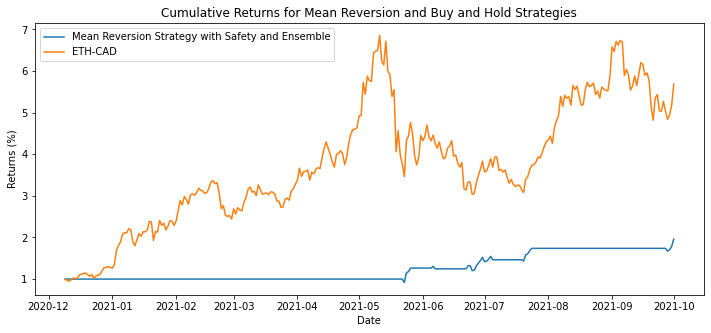

Safe+Ensemble Strategy Statistics 

                       strat_stats  base_stats
tot_returns                  0.962       4.882
annual_returns               0.772       3.497
annual_volatility            0.330       0.943
max_drawdown                 0.120       5.455
max_drawdown_duration       17.000     143.000


In [14]:
#Set strategy params
ticker = 'ETH-CAD'
start_date = '2020-11-30'
end_date = '2021-10-01'
strat='SMA_MR'
verbose = False
safety = True
SMA = 50
threshold = 0.10
safety_threshold = 0.15
short_term_sma=10
long_term_sma=20
short_long_threshold=0.05
#Pack the strategy settings
strat_settings1 = [ticker, strat, SMA, threshold, safety, safety_threshold, short_term_sma, long_term_sma, short_long_threshold, start_date,end_date]

#Run the backtest
data_safe_ensemble = stratBacktest(strat_settings1)
safe_ensemble_stats_dict = getStratStats(data_safe_ensemble)
df_safe_ensemble_stats = pd.DataFrame(safe_ensemble_stats_dict).round(3)

#Normalize backtest results
first_valid_day = data_safe_ensemble.first_valid_index()
data_normalized = data_safe_ensemble/data_safe_ensemble.loc[first_valid_day]

#Plot the results
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_normalized['strat_cum_returns'], label='Mean Reversion Strategy with Safety and Ensemble')
ax.plot(data_normalized['cum_returns'], label=f'{ticker}')
ax.set_xlabel('Date')
ax.set_ylabel('Returns (%)')
ax.set_title('Cumulative Returns for Mean Reversion and Buy and Hold Strategies')

ax.legend()
plt.show()

print('Safe+Ensemble Strategy Statistics \n')
print(df_safe_ensemble_stats)

### Get portfolio decisions for today

In [15]:
#List of stocks we want to consider in our portfolio
#tickers = ['ETH-CAD','BTC-CAD','ADA-CAD','BNB-CAD','SNP','GOOGL','AAPL']
tickers = ['BTC-CAD','CRV-CAD','COMP-CAD','ETH-CAD','LINK-CAD']
#tickers = ['AAVE-CAD','BAL-CAD','BAT-CAD','BCH-CAD','BTC-CAD','COMP-CAD','CRV-CAD','DOGE-CAD','ETH-CAD','FIL-CAD','KNC-CAD','LINK-CAD','LTC-CAD','MANA-CAD','MATIC-CAD','MKR-CAD','SNX-CAD','SUSHI-CAD','UMA-CAD','UNI3-CAD','YFI-CAD','ZRX-CAD']
#tickers = ['TSLA','AAPL','TD','AMZN','SHOP','MSFT','RY','BNS','NVDA','CNR','BMO','FTS','ARKK','ABNB','NFLX','COIN','FB','BCE','VOO','DOL','SQ','KO','GOOGL','WMT']
current_positions = [0]*len(tickers)

#Set strategy params
strat_func = SMAMeanReversion_strat
SMA = 50
threshold = 0.1
safety = False
safety_threshold = 0.15
short_term_sma=30 
long_term_sma=90
short_long_threshold=0.05
#Pack the strategy settings
strat_settings2 = [strat_func, tickers, current_positions, SMA, threshold, safety, safety_threshold, short_term_sma, long_term_sma, short_long_threshold]

#Apply strategy to portfolio
decisions = applyPortfolioStrat(strat_settings2)
decisions

,ticker,current_price,expected_price,extension,extension_position,short_long ratio,short_long_position,movement,take_profit_price,position
Date,,,,,,,,,,
2021-10-17,BTC-CAD,76170.078,60006.370,0.233,0.0,1.076,0.0,Hold,0.000,0.0
2021-10-17,CRV-CAD,3.550,3.030,0.103,0.0,1.181,0.0,Hold,0.000,0.0
2021-10-17,COMP-CAD,384.940,485.516,-0.177,1.0,0.820,1.0,Buy,455.343,1.0
2021-10-17,ETH-CAD,4760.634,4134.666,0.106,0.0,1.057,0.0,Hold,0.000,0.0
2021-10-17,LINK-CAD,32.843,32.903,-0.031,0.0,1.007,0.0,Hold,0.000,0.0


### Run a portfolio backtest

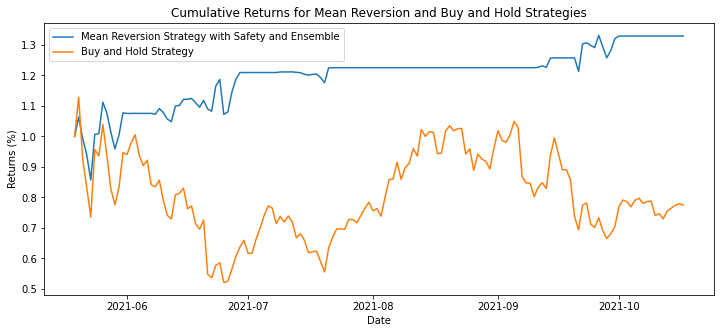

Portfolio Backtest Statistics


,strat_stats,base_stats
tot_returns,0.566,17.245
annual_returns,0.382,4.837
annual_volatility,0.463,1.673
max_drawdown,0.243,29.668
max_drawdown_duration,21.000,150.000


In [16]:
#List of stocks we want to consider in our portfolio
tickers = ['AAVE-CAD','BAL-CAD','BAT-CAD','BCH-CAD','BTC-CAD','COMP-CAD','CRV-CAD','DOGE-CAD','ETH-CAD','FIL-CAD','KNC-CAD','LINK-CAD','LTC-CAD','MANA-CAD','MATIC-CAD','MKR-CAD','SNX-CAD','SUSHI-CAD','UMA-CAD','UNI3-CAD','YFI-CAD','ZRX-CAD']
#tickers = ['TSLA','AAPL','TD','AMZN','SHOP','MSFT','RY','BNS','NVDA','CNR','BMO','FTS','ARKK','NFLX','FB','BCE','VOO','DOL','SQ','KO','GOOGL','WMT']
#tickers = ['SNP','GOOGL','AAPL','TD','AMZN','BMO','CNR','NVDA','ARKK','NFLX','FB','VOO','GOOGL','WMT']
#tickers = ['BAL-CAD','BAT-CAD','BCH-CAD','BTC-CAD','COMP-CAD']
#tickers = ['SNP','TSLA']
verbose = False

start_date = '2020-05-01'
end_date = '2021-10-17'
strat='SMA_MR'
SMA = 15
threshold = 0.1
safety = False
safety_threshold = 0.15
short_term_sma=10
long_term_sma=30
short_long_threshold=0.05

strat_settings3 = [tickers, strat, SMA, threshold, safety, safety_threshold, short_term_sma, long_term_sma, short_long_threshold, start_date, end_date, verbose]
#Run the backtest on the entire portfolio
portfolio_returns, portfolio_stats = portfolioBacktest(strat_settings3)
#Plot portfolio backtest returns
plot_portfolio_backtest(portfolio_returns)
#Print portfolio backtest statistics
print('Portfolio Backtest Statistics')
round(portfolio_stats,3)

In [6]:
portfolio_returns.first_valid_index()

Timestamp('2020-04-13 00:00:00')

In [7]:
start_date = '2021-10-01'
end_date = '2021-10-07'
ticker = 'BTC-CAD'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start=start_date, end=end_date)

print(yfObj.info['regularMarketPrice']) #yfObj.info call is pretty slow, would be nice if there's a faster way to get current price

76326.89
